In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bayes_opt import BayesianOptimization
from dotenv import find_dotenv, load_dotenv
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

from src.visualization.visualize import (
    crossvalidate_pipeline_scores,
    plot_scores,
    train_and_plot_prediction_metrics,
)

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123



In [2]:

data = pd.read_csv(os.path.join("data", "processed", "galaxy.csv"))


In [3]:

target = "galaxysentiment"

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=target), data[target], test_size=0.2, random_state=random_state
)


 # Comparison of Scalers

 * Gradient boosting does not necessarily benefit from scaling, but lets try
 * Creating a pipeline for three different scaler options and no scaling
 * Does not make a difference so lets not scale

In [4]:

scaler_pipelines = {
    "robust_scaler": make_pipeline(
        VarianceThreshold(), RobustScaler(), GradientBoostingRegressor()
    ),
    "standard_scaler": make_pipeline(
        VarianceThreshold(), StandardScaler(), GradientBoostingRegressor()
    ),
    "min_max_scaler": make_pipeline(
        VarianceThreshold(), MinMaxScaler(), GradientBoostingRegressor()
    ),
    "no_scaling": make_pipeline(VarianceThreshold(), GradientBoostingRegressor()),
}


Crossvalidating robust_scaler
Crossvalidating standard_scaler
Crossvalidating min_max_scaler
Crossvalidating no_scaling


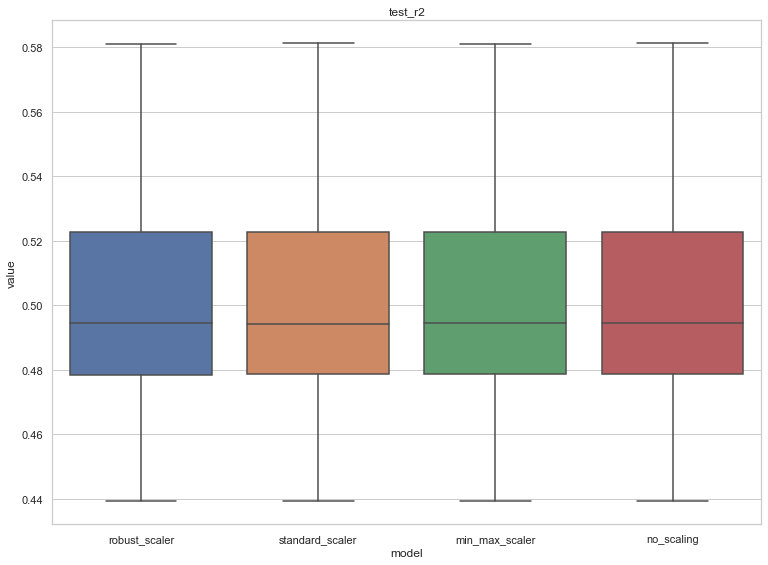

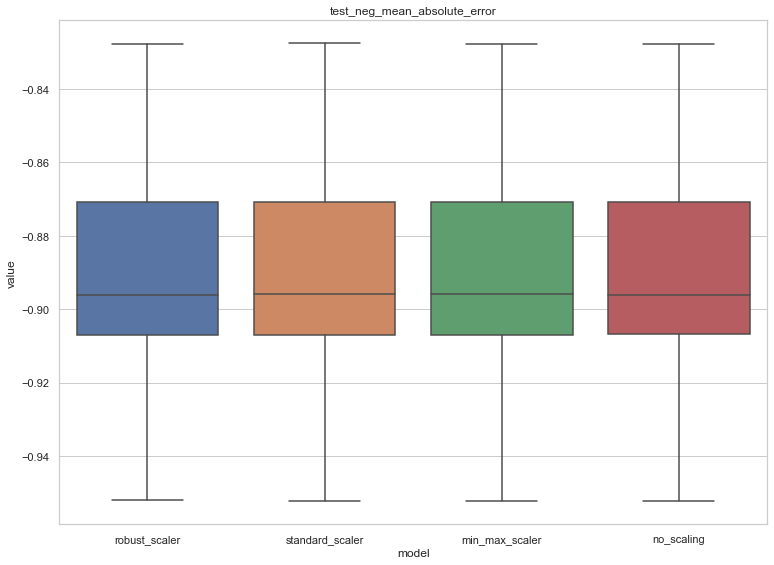

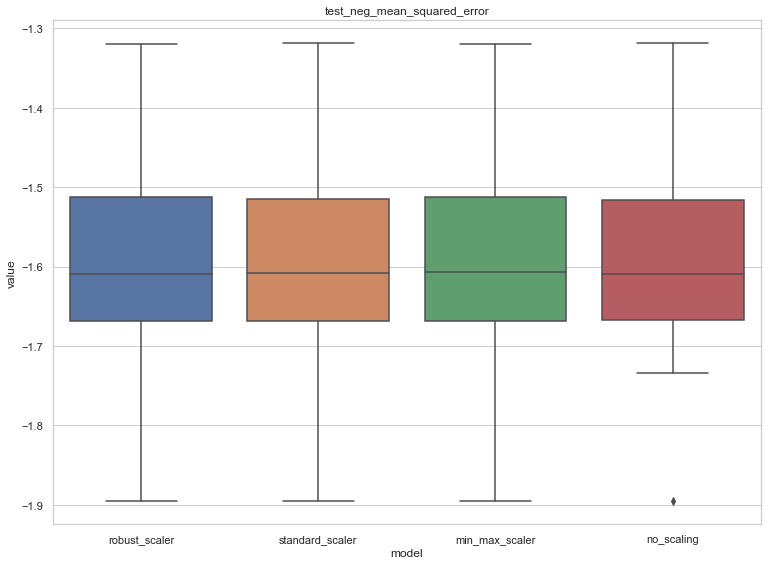

In [5]:

scores = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=scaler_pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores)


 # Optimizing the Hyperparameters for Model Without Feature Selection

 * Using scoring metric of mean squared error and bayesian optimization

In [6]:


def gradient_boosting_cv(max_depth, min_samples_split, min_samples_leaf, max_features):
    pipeline = make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=int(max_features),
        ),
    )
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, cv=3, scoring="neg_mean_squared_error", n_jobs=3
    )
    return cv_scores.mean()


parameter_bounds = {
    "max_depth": (4, 7),
    "min_samples_split": (2, 100),
    "min_samples_leaf": (4, 10),
    "max_features": (3, X_train.shape[1]),
}

optimizer = BayesianOptimization(
    f=gradient_boosting_cv,
    pbounds=parameter_bounds,
    verbose=2,
    random_state=random_state,
)

optimizer.maximize(init_points=50, n_iter=50)
print(optimizer.max)



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
|  1        | -2.94     |  6.089    |  10.15    |  5.361    |  56.03    |
|  2        | -2.929    |  6.158    |  13.58    |  9.885    |  69.11    |
|  3        | -2.936    |  5.443    |  12.8     |  6.059    |  73.45    |
|  4        | -3.026    |  5.316    |  4.492    |  6.388    |  74.32    |
|  5        | -2.996    |  4.547    |  7.386    |  7.189    |  54.12    |
|  6        | -2.922    |  5.903    |  24.24    |  8.347    |  61.88    |
|  7        | -2.929    |  6.167    |  11.07    |  6.171    |  24.37    |
|  8        | -2.93     |  4.881    |  18.77    |  4.553    |  44.5     |
|  9        | -2.928    |  5.293    |  15.34    |  6.555    |  32.6     |
|  10       | -2.922    |  5.279    |  25.33    |  9.665    |  51.18    |
|  11       | -2.997    |  5.872    |  5.89     |  5.904    |  42.65    |
|  12       | -2.945    |  6.599    | 

In [7]:

selector = RFECV(
    GradientBoostingRegressor(
        learning_rate=0.001,
        n_estimators=100,
        max_depth=7,
        min_samples_split=28,
        min_samples_leaf=10,
        # this causes errors
        # max_features=27,
    ),
    step=1,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=3,
)
selector = selector.fit(X_train, y_train)
columns_to_keep = X_train.columns[selector.support_]
print("Columns to keep:", columns_to_keep)
print(
    "Proportion of features kept:",
    round(len(columns_to_keep) * 100 / len(X_train.columns), 1),
    "%",
)



Columns to keep: Index(['iphone', 'samsunggalaxy', 'googleandroid', 'iphonecampos',
       'samsungcampos', 'iphonecamneg', 'samsungcamneg', 'iphonecamunc',
       'samsungcamunc', 'iphonedispos', 'samsungdispos', 'iphonedisneg',
       'samsungdisneg', 'iphonedisunc', 'samsungdisunc', 'iphoneperpos',
       'samsungperpos', 'iphoneperneg', 'iphoneperunc', 'samsungperunc'],
      dtype='object')
Proportion of features kept: 71.4 %


 # Optimizing the Hyperparameters for Model with Feature Selection

 * Using scoring metric of mean squared error

In [8]:


def gradient_boosting_cv(max_depth, min_samples_split, min_samples_leaf, max_features):
    pipeline = make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=int(max_features),
        ),
    )
    cv_scores = cross_val_score(
        pipeline,
        X_train[columns_to_keep],
        y_train,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=3,
    )
    return cv_scores.mean()


parameter_bounds = {
    "max_depth": (4, 7),
    "min_samples_split": (2, 100),
    "min_samples_leaf": (4, 10),
    "max_features": (3, X_train[columns_to_keep].shape[1]),
}

optimizer = BayesianOptimization(
    f=gradient_boosting_cv,
    pbounds=parameter_bounds,
    verbose=2,
    random_state=random_state,
)

optimizer.maximize(init_points=50, n_iter=50)
print(optimizer.max)



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
|  1        | -2.942    |  6.089    |  7.864    |  5.361    |  56.03    |
|  2        | -2.926    |  6.158    |  10.19    |  9.885    |  69.11    |
|  3        | -2.933    |  5.443    |  9.666    |  6.059    |  73.45    |
|  4        | -2.992    |  5.316    |  4.015    |  6.388    |  74.32    |
|  5        | -2.983    |  4.547    |  5.983    |  7.189    |  54.12    |
|  6        | -2.922    |  5.903    |  17.44    |  8.347    |  61.88    |
|  7        | -2.93     |  6.167    |  8.49     |  6.171    |  24.37    |
|  8        | -2.928    |  4.881    |  13.73    |  4.553    |  44.5     |
|  9        | -2.928    |  5.293    |  11.39    |  6.555    |  32.6     |
|  10       | -2.922    |  5.279    |  18.19    |  9.665    |  51.18    |
|  11       | -2.992    |  5.872    |  4.966    |  5.904    |  42.65    |
|  12       | -2.938    |  6.599    | 

 # Performance of the optimized models

Crossvalidating default_model
Crossvalidating default_model_feature_selection
Crossvalidating optimized_model_for_no_feature_selection
Crossvalidating optimized_model_for_no_feature_feature_selection
Crossvalidating optimized_model
Crossvalidating optimized_model_feature_selection


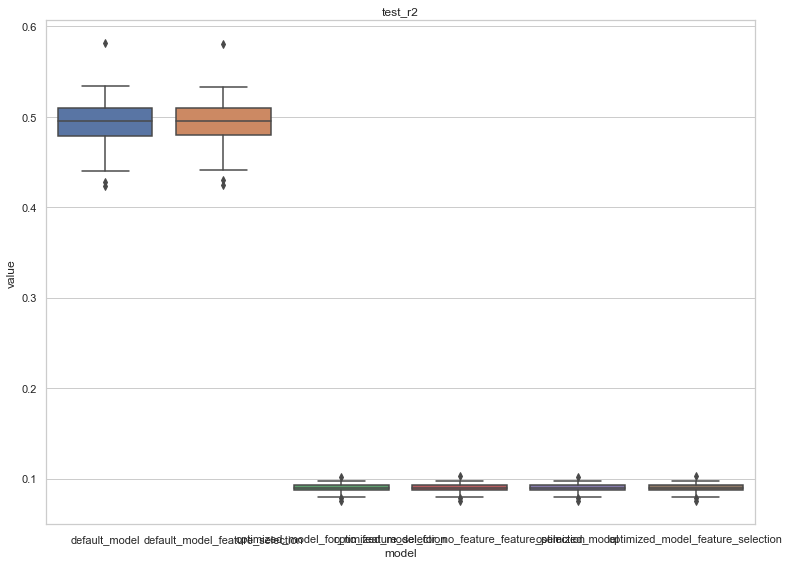

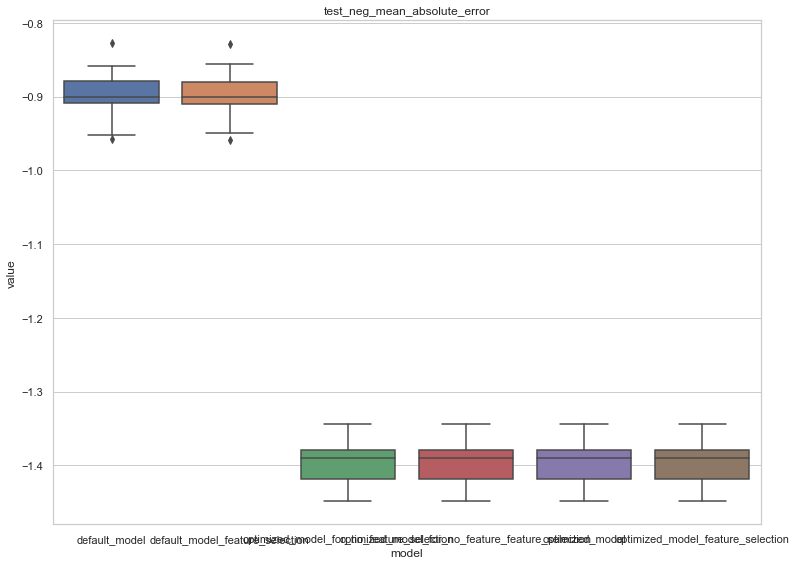

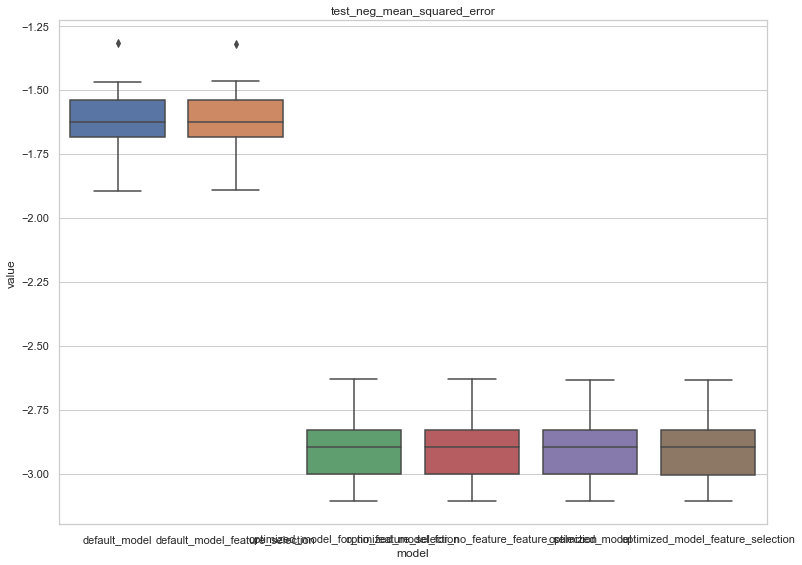

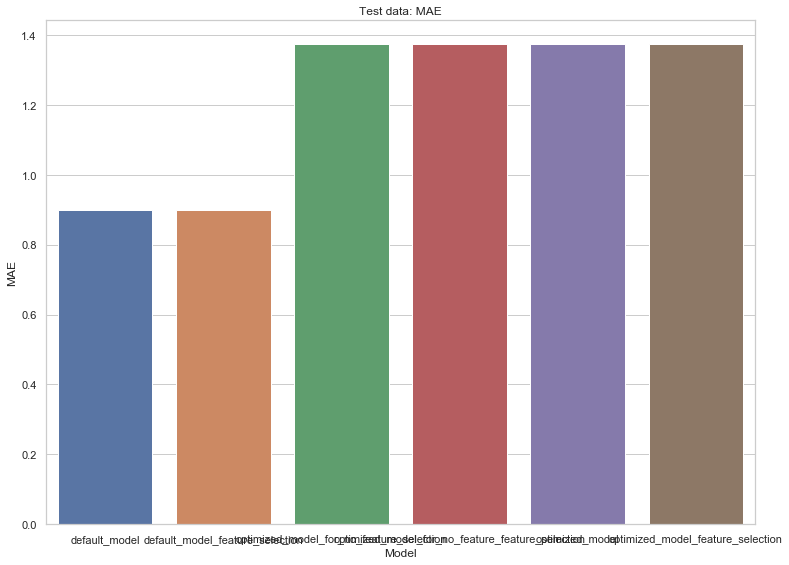

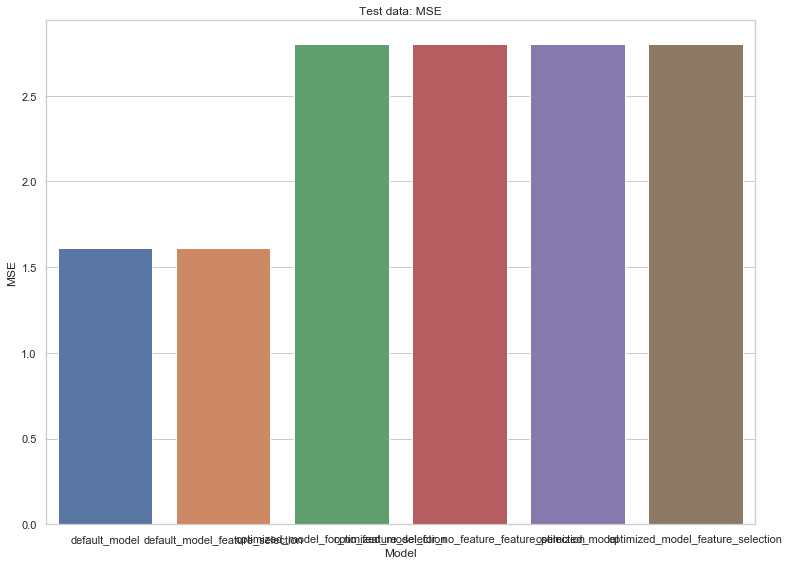

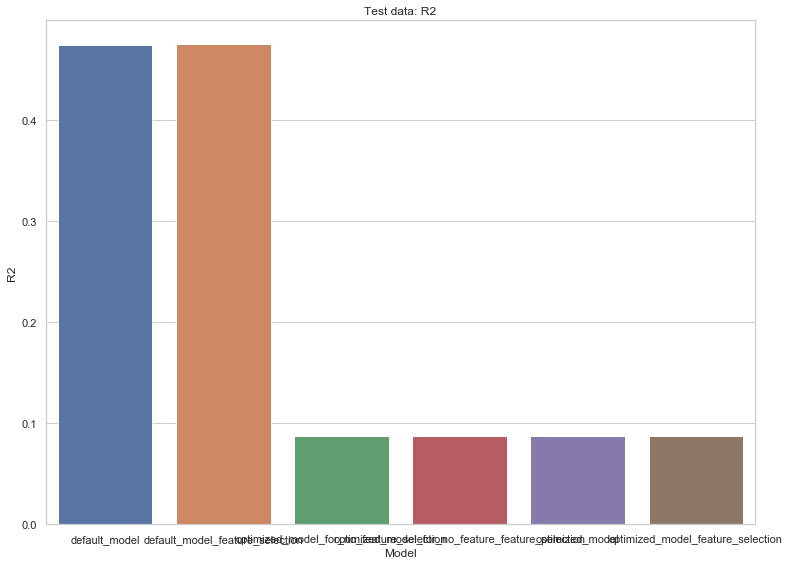

In [9]:


def drop_preselected_columns(X):
    return X[:, selector.support_]


final_pipelines = {
    "default_model": make_pipeline(VarianceThreshold(), GradientBoostingRegressor()),
    "default_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        GradientBoostingRegressor(),
    ),
    "optimized_model_for_no_feature_selection": make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=7,
            min_samples_split=28,
            min_samples_leaf=10,
            # max_features=15,
        ),
    ),
    "optimized_model_for_no_feature_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=7,
            min_samples_split=28,
            min_samples_leaf=10,
            # max_features=15,
        ),
    ),
    "optimized_model": make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=7,
            min_samples_split=2,
            min_samples_leaf=10,
            # max_features=15,
        ),
    ),
    "optimized_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=7,
            min_samples_split=2,
            min_samples_leaf=10,
            # max_features=15,
        ),
    ),
}

scores_optimized = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=final_pipelines,
    n_splits=30,
    random_state=random_state,
)

plot_scores(scores=scores_optimized)

train_and_plot_prediction_metrics(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipelines=final_pipelines,
)

